In [20]:
using ModelingToolkit
using DifferentialEquations
using Plots
using ModelingToolkit: t_nounits as t, D_nounits as D, @variables, @parameters, @named, @unpack, @mtkbuild
using Symbolics

In [21]:
mutable struct Wall
    rho::Float64
    V::Float64
    m::Float64
    Cp::Float64
    m_elem::Float64
end
mutable struct Ref
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    Ge1::Float64
    Ge2::Float64
end
mutable struct Fld
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    k::Float64
    Pr::Float64
    rho::Float64
    mu::Float64
    Cp::Float64
    mdot::Float64
    T_in::Float64
end
mutable struct HX_PHX
    N_t::Int64
    N_c::Int64
    N_f::Int64
    L_w::Float64
    L_v::Float64
    A_t::Float64
    phi::Float64
    p::Float64
    t::Float64
    b::Float64
    D_h::Float64
    beta::Float64
    N_CV::Int64
    Wall::Wall
    Ref::Ref
    Fld::Fld
    isCounterFlow::Bool
end

In [73]:
function make_HX(N_t::Int64, L_w::Float64, L_v::Float64, A_t::Float64, p::Float64, t::Float64, N_CV::Int64, isCounterFlow::Bool)
    # DIC-193-33 PHX. http://www.dibr.co.kr/exchanger/detail/D93RP00056?ts=1735978818&capacity=0.5&cate=162&
    N_t = N_t
    N_c = (N_t - 1) / 2
    N_f = (N_t - 1) / 2
    L_w = L_w
    L_v = L_v
    A_t = A_t
    ϕ = A_t / (L_w * L_v * (N_t - 2))
    p = p
    t = t
    b = p - t
    D_h = 2 * b / ϕ
    β = 25 * pi / 180
    N_CV = N_CV

    # Wall Geo, Props
    Wall_rho = 7.93e3 # STS 304 density
    Wall_V = A_t * t
    Wall_m = Wall_V * Wall_rho
    Wall_Cp = 502 # specific heat

    # Ref, Fld Geo
    Ref_V = N_c * L_w * b* L_v
    Ref_A_cs = N_c * L_w * b
    Fld_V =  N_f * L_w * b * L_v
    Fld_A_cs = N_f * L_w * b

    # Geo per Element
    Wall_m_elem = Wall_m / N_CV
    Ref_V_elem = Ref_V / N_CV
    Ref_A_elem = A_t / N_CV
    Fld_V_elem = Fld_V / N_CV
    Fld_A_elem = Ref_A_elem

    # Ref UA Props
    Ref_Ge1 = 11.22*(b/D_h)^(-2.83) * (pi/2 - β)^(-4.5)
    Ref_Ge2 = 0.35*(b/D_h)^(0.23) * (pi/2 - β)^(1.48)

    # Fld Props (Water, 15C, Saturated Liquid, refprop)
    Fld_k = 0.5887
    Fld_Pr = 1.7058
    Fld_rho = 999.0561
    Fld_mu = 0.0011
    Fld_Cp = 4.1888e3

    # Fld
    Fld_mdot = 0.1
    Fld_T_in = 273.15 + 40
    isCounterFlow = isCounterFlow

    HX_Wall = Wall(Wall_rho, Wall_V, Wall_m, Wall_Cp, Wall_m_elem)
    HX_Ref = Ref(Ref_V, Ref_A_cs, Ref_V_elem, Ref_A_elem, Ref_Ge1, Ref_Ge2)
    HX_Fld = Fld(Fld_V, Fld_A_cs, Fld_V_elem, Fld_A_elem, Fld_k, Fld_Pr, Fld_rho, Fld_mu, Fld_Cp, Fld_mdot, Fld_T_in)
    return HX_PHX(N_t, N_c, N_f, L_w, L_v, A_t, ϕ, p, t, b, D_h, β, N_CV, HX_Wall, HX_Ref, HX_Fld, isCounterFlow)
end
# HX_C
HX_C_N_t = 33
HX_C_L_w = 0.083
HX_C_L_v = 0.154
HX_C_A_t = 0.434
HX_C_p = 2.35e-3
HX_C_t = 0.4e-3
HX_C_N_CV = 20
HX_C_isCounterFlow = true
HX_C = make_HX(HX_C_N_t, HX_C_L_w, HX_C_L_v, HX_C_A_t, HX_C_p, HX_C_t, HX_C_N_CV, HX_C_isCounterFlow)

HX_PHX(33, 16, 16, 0.083, 0.154, 0.434, 1.095290251916758, 0.00235, 0.0004, 0.0019500000000000001, 0.0035607, 0.4363323129985824, 20, Wall(7930.0, 0.00017360000000000002, 1.376648, 502.0, 0.0688324), Ref(0.0003987984000000001, 0.0025896000000000005, 1.9939920000000003e-5, 0.0217, 34.95278503589673, 0.3672934117781399), Fld(0.0003987984000000001, 0.0025896000000000005, 1.9939920000000003e-5, 0.0217, 0.5887, 1.7058, 999.0561, 0.0011, 4188.8, 0.1, 313.15), true)

In [74]:
# Q11. MTK ver
using CoolProp
# CoolProp with MTK (Tabular / Consider to change into PINN)
 # ρ, T from P, h
handle = CoolProp.AbstractState_factory("HEOS&BICUBIC", "R410A")

function R410a_density(P, h)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("HmassP_INPUTS"), h, P)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end

function R410a_temperature(P, h)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("HmassP_INPUTS"), h, P)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("T"))
end

# Q  = 0, 1 // Q = 0 Props of Ref
function R410a_h_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Hmass"))
end
function R410a_h_V(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Hmass"))
end
function R410a_rho_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end
function R410a_rho_V(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end

function R410a_k_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("L"))
end
function R410a_mu_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("V"))
end
function R410a_Pr_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Prandtl"))
end

R410a_x(P,h) = (h - R410a_h_L(P)) / (R410a_h_V(P) - R410a_h_L(P))

# Symbolics
@register_symbolic R410a_density(P, h) 
@register_symbolic R410a_temperature(P, h)

@register_symbolic R410a_h_L(P)
@register_symbolic R410a_h_V(P)
@register_symbolic R410a_rho_L(P)
@register_symbolic R410a_rho_V(P)

@register_symbolic R410a_k_L(P)
@register_symbolic R410a_mu_L(P)
@register_symbolic R410a_Pr_L(P)

@register_symbolic R410a_x(P, h)

# Symbolics_Der
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{1}) = R410a_density(args[1]+0.5, args[2]) -  R410a_density(args[1]-0.5, args[2])
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{2}) = R410a_density(args[1], args[2]+0.5) -  R410a_density(args[1], args[2]-0.5)

function R410a_dρdP_h(P,h)
    return (R410a_density(P+0.5, h) - R410a_density(P-0.5, h))
end
function R410a_dρdh_P(P,h)
    return (R410a_density(P, h+0.5) - R410a_density(P, h-0.5))
end
@register_symbolic R410a_dρdP_h(P,h)
@register_symbolic R410a_dρdh_P(P,h)

In [102]:
# (Qiao et al. 2022), regPow_gen
function regPow(x, a, b, δ)
    return x^b * (x*x + δ*δ)^((a-b) / 2)
end
function regSqrt(x)
    return regPow(x, 0.5, 3, 0.001)
end

regSqrt (generic function with 3 methods)

In [103]:
# Func for UA_elem
function U_func(P, h, mdot_in, HX_Arr)
    x = R410a_x(P, h)
    ref_k_L = R410a_k_L(P)
    ref_mu_L = R410a_mu_L(P)
    ref_Pr_L = R410a_Pr_L(P)
    ref_rho_L = R410a_rho_L(P)
    ref_rho_V = R410a_rho_V(P)
    
    HX_D_h = HX_Arr[1]
    HX_beta = HX_Arr[2]
    HX_Ref_A_cs = HX_Arr[3]
    HX_Ref_Ge1 = HX_Arr[4]
    HX_Ref_Ge2 = HX_Arr[5]

    # Single phase 
    G = mdot_in / HX_Ref_A_cs
    Re_L = G * HX_D_h / ref_mu_L
    U_ref_single = 0.295 * (ref_k_L/HX_D_h) * ifelse(Re_L >= 0.0, regPow(Re_L, 0.64, 3, 0.1), 0.0) * ref_Pr_L^0.32 * (π/2 - HX_beta)^0.09

    # Two phase
    G_eq_tp = G * (1-x + x*(ref_rho_L/ref_rho_V)^0.5)
    Re_eq_tp = G_eq_tp * HX_D_h / ref_mu_L
    U_ref_tp = HX_Ref_Ge1 * (ref_k_L/HX_D_h) * ifelse(Re_eq_tp >= 0.0, regPow(Re_eq_tp, HX_Ref_Ge2, 3, 0.1), 0.0) * ref_Pr_L^(1/3)

    slope1 = (U_ref_tp - U_ref_single) / 0.1
    slope2 = (U_ref_single - U_ref_tp) / 0.1 # slope2 == -slope1

    # Smoothing with ifelse
    U_ref = U_ref_single +
           ifelse(x > 0.0, slope1 * (x - 0.0), 0) +      # x=0, 0 -> slope1
           ifelse(x > 0.1, -slope1 * (x - 0.1), 0) +     # x=0.1, slope1 -> 0
           ifelse(x > 0.9, slope2 * (x - 0.9), 0) +      # x=0.9, 0 -> slope2
           ifelse(x > 1.0, -slope2 * (x - 1.0), 0)       # x=1.0, slope2 -> 0

    return U_ref
end

U_func (generic function with 135 methods)

In [104]:
# Func for h_flow
# Qiao et al. (2015) : Transient modeling of a flash tank vapor injection heat pump system - Part I: Model development
function h_flow_func(P, h)
    x = R410a_x(P, h)
    # Single phase
    if abs(x - 0.5) >= 0.5   
        return h
    end
    ρ = R410a_density(P, h)
    ref_h_L = R410a_h_L(P)
    ref_h_V = R410a_h_V(P)
    ref_rho_L = R410a_rho_L(P)
    ref_rho_V = R410a_rho_V(P)
    

    # Two phase
    γ = (ρ - ref_rho_L) / (ref_rho_V - ref_rho_L) 
    # Zivi (1964) : c = 1, q = 1, r = (2/3), s = 0
    # c, q, r = 1.0, 1.0, 2/3
    # Smith (1969) : c = 0.79, q = 0.78, r = 0.58, s = 0
    c, q, r = 0.79, 0.78, 0.58
    x_flow = γ^(1/q) / (γ^(1/q) + ((1/c)*(ref_rho_L / ref_rho_V)^(r))^(1/q) * (1 - γ)^(1/q) )

    h_flow = h + (x_flow - x) * (ref_h_V - ref_h_L)
    return h_flow
end

h_flow_func (generic function with 9 methods)

In [105]:
@register_symbolic regPow(x, a, b, δ)
@register_symbolic regSqrt(x)
@register_symbolic U_func(P, h, mdot_in, HX_Arr::Symbolics.Arr{Num,5})
@register_symbolic h_flow_func(P, h)

In [106]:
# Fld UA_elem calc / Const
function U_func_Fld(HX::HX_PHX)
    G = HX.Fld.mdot / HX.Fld.A_cs
    Re_Fld = G * HX.D_h / HX.Fld.mu
    U_ref_Fld = 0.295 * (HX.Fld.k/HX.D_h) * Re_Fld^0.64 * HX.Fld.Pr^0.32 * (π/2 - HX.beta)^0.09
    return U_ref_Fld
end

U_func_Fld (generic function with 1 method)

In [107]:
# 1. Params, Variables for Ref
N = HX_C.N_CV
U_Fld_elem = U_func_Fld(HX_C)

# Init Props
P_in_val = 3200e3
P_out_val = 3000e3
h_in_val = 450e3
c1_val = 9e-6
c2_val = c1_val

9.0e-6

In [108]:
# 1. Params for HX
# 1-0. Init cond
@parameters begin
    c1=c1_val 
    c2=c2_val
    P_in=P_in_val
    P_out=P_out_val
    h_init=h_in_val 
    ρ_init=R410a_density(P_in_val, h_in_val)
    Δt = 0.01  #[s]
end

# 1-1. Ref side
@parameters begin
    HX_Arr[1:5] = [HX_C.D_h, HX_C.beta, HX_C.Ref.A_cs, HX_C.Ref.Ge1, HX_C.Ref.Ge2]
    HX_Ref_A_elem = HX_C.Ref.A_elem
    HX_Ref_V_elem = HX_C.Ref.V_elem
end
# 1-2. Wall Side
@parameters begin
    HX_Wall_m_elem = HX_C.Wall.m_elem
    HX_Wall_Cp = HX_C.Wall.Cp
end
# 1-3. Fld Side
@parameters begin
    HX_Fld_mdot_in = HX_C.Fld.mdot
    HX_Fld_T_in = HX_C.Fld.T_in
    HX_Fld_A_elem = HX_C.Fld.A_elem
    HX_Fld_Cp = HX_C.Fld.Cp
    UA_Fld_elem = U_Fld_elem * HX_C.Fld.A_elem # UA const for Fld side
end

# 2. Variables for HX
# 2-1. Ref Side
    # Static
@variables begin
    P(t)
    h(t)[1:N]
    ρ(t)[1:N]
    T(t)[1:N]
    UA_elem(t)[1:N]
    UA_elem_hat(t)[1:N]
end
    # Flow
@variables begin
    mdot_in(t)[1:N]
    mdot_out(t)[1:N]
    # h_in(t)[1:N]
    # h_out(t)[1:N]
    # H_in(t)[1:N]
    # H_out(t)[1:N]
    Q_r(t)[1:N]
end
# 2-2. Wall Side
@variables T_wall(t)[1:N]
# 2-3. Fld Side
    # Static
@variables begin
    T_Fld(t)[1:N+1]
end
    # Flow
@variables begin
    Q_f(t)[1:N]
end

1-element Vector{Symbolics.Arr{Num, 1}}:
 (Q_f(t))[1:20]

In [109]:
# 4. Equations
# 4-1. Cond
# 4-1.1 Cond_Ref_side
# dP/dt method
cond_Ref = [
    [
    # 1-1. Algebraic eqns for Ref
    # Static vars cal
    ρ[i] ~ R410a_density(P, h[i]), T[i] ~ R410a_temperature(P, h[i]),
    
    # Flow vars cal(mdot[i], h_out[i], H_in[i], H_out[i] : By Static vars P, h[i], ρ[i])
    mdot_in[i] ~ (i == 1 ? ifelse(P_in - P > 0.0, c1 * (regSqrt(ρ_init * (P_in - P))), 0.0) : mdot_out[i-1]),
    mdot_out[i] ~ (i == N ? ifelse(P - P_out > 0.0, c2 * (regSqrt(ρ[i] * (P - P_out))), 0.0) : mdot_in[i+1]),
    
    # h_in[i] ~ (i == 1 ? h_flow_func(P_in, h_init) : h_out[i-1]),
    # h_out[i] ~ h_flow_func(P, h[i]),
    # H_in[i] ~ mdot_in[i] * h_in[i],
    # H_out[i] ~ mdot_out[i] * h_out[i],
    
    # Flow vars cal(Q_r[i] : By Static vars (P, h[i], ρ[N]), T)
    # (Qiao et al., 2018) On Closure Relations for Dynamic Vapor Compression Cycle models
    UA_elem_hat[i] ~ U_func(P, h[i], mdot_in[i], HX_Arr) * HX_Ref_A_elem,
    # Low Pass Filtering of UA_elem
    D(UA_elem[i]) ~ (UA_elem_hat[i] - UA_elem[i]) / Δt,
    Q_r[i] ~ UA_elem[i] * (T_wall[i] - T[i]),
    
    # 1-2. Differential eqns for Ref [Static vars diff by flow vars(H_in, H_out, Q_r)]
    HX_Ref_V_elem * (R410a_dρdP_h(P, h[i]) * D(P) + R410a_dρdh_P(P, h[i]) * D(h[i])) ~ (mdot_in[i] - mdot_out[i]),
    HX_Ref_V_elem * ((h[i] * R410a_dρdP_h(P, h[i]) - 1) * D(P) + (h[i] * R410a_dρdh_P(P, h[i]) + ρ[i]) * D(h[i])) ~ mdot_in[i] * (i == 1 ? h_flow_func(P_in, h_init) : h_flow_func(P, h[i-1])) - mdot_out[i] * h_flow_func(P, h[i]) + Q_r[i],

    ]
    for i in 1:N
]

if HX_C.isCounterFlow == true
    # 4-1.2 Cond_Wall_side
    cond_Wall = [
        [
            # 2-1. Algebraic eqns for Wall
            # 2-2. Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[N+1-i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # 4-1.3 Cond_Fld_side
    cond_Fld = [
        [
            # 3-1. Algebraic eqns for Fld
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[N+1-i] - T_wall[i]),
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[N+1-i] - T_Fld[N+2-i])
        ]
        for i in 1:N
    ]
else
    # 4-1.2 Cond_Wall_side
    cond_Wall = [
        [
            # 2-1. Algebraic eqns for Wall
            # 2-2. Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # 4-1.3 Cond_Fld_side
    cond_Fld = [
        [
            # 3-1. Algebraic eqns for Fld
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[i] - T_wall[i]),
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[i+1] - T_Fld[i])
        ]
        for i in 1:Nc
    ]
end
push!(cond_Fld, [T_Fld[1] ~ HX_Fld_T_in])


# Flatten the cond models
cond_eqns = vcat(cond_Ref, cond_Wall, cond_Fld)
cond_model = [cond_eq for cond_eq_vec in cond_eqns for cond_eq in cond_eq_vec]

241-element Vector{Equation}:
 (ρ(t))[1] ~ Main.R410a_density(P(t), (h(t))[1])
 (T(t))[1] ~ Main.R410a_temperature(P(t), (h(t))[1])
 (mdot_in(t))[1] ~ ifelse((P_in - P(t)) > 0.0, c1*Main.regSqrt((P_in - P(t))*ρ_init), 0.0)
 (mdot_out(t))[1] ~ (mdot_in(t))[2]
 (UA_elem_hat(t))[1] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[1], (mdot_in(t))[1], HX_Arr)
 Differential(t)((UA_elem(t))[1]) ~ (-(UA_elem(t))[1] + (UA_elem_hat(t))[1]) / Δt
 (Q_r(t))[1] ~ (-(T(t))[1] + (T_wall(t))[1])*(UA_elem(t))[1]
 HX_Ref_V_elem*(Main.R410a_dρdP_h(P(t), (h(t))[1])*Differential(t)(P(t)) + Main.R410a_dρdh_P(P(t), (h(t))[1])*Differential(t)((h(t))[1])) ~ (mdot_in(t))[1] - (mdot_out(t))[1]
 HX_Ref_V_elem*((-1 + (h(t))[1]*Main.R410a_dρdP_h(P(t), (h(t))[1]))*Differential(t)(P(t)) + ((ρ(t))[1] + (h(t))[1]*Main.R410a_dρdh_P(P(t), (h(t))[1]))*Differential(t)((h(t))[1])) ~ (Q_r(t))[1] + (mdot_in(t))[1]*Main.h_flow_func(P_in, h_init) - (mdot_out(t))[1]*Main.h_flow_func(P(t), (h(t))[1])
 (ρ(t))[2] ~ Main.R410a_density(P(t),

In [110]:
@mtkcompile sys = ODESystem(cond_model, t; continuous_events = [P - P_out ~ 0])

Model sys:
Equations (82):
  82 standard: see equations(sys)
Unknowns (82): see unknowns(sys)
  (T_wall(t))[20]
  (T_wall(t))[19]
  (T_wall(t))[18]
  (T_wall(t))[17]
  (T_wall(t))[16]
  (T_wall(t))[15]
  ⋮
Parameters (16): see parameters(sys)
  HX_Wall_Cp [defaults to 502.0]
  HX_Fld_T_in [defaults to 313.15]
  ρ_init [defaults to 119.638]
  HX_Fld_Cp [defaults to 4188.8]
  HX_Arr [defaults to [0.0035607, 0.436332, 0.0025896, 34.9528, 0.367293]]
  HX_Ref_V_elem [defaults to 1.99399e-5]
  ⋮
Observed (169): see observed(sys)

In [111]:
unknowns(sys)

82-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 (T_wall(t))[20]
 (T_wall(t))[19]
 (T_wall(t))[18]
 (T_wall(t))[17]
 (T_wall(t))[16]
 (T_wall(t))[15]
 (T_wall(t))[14]
 (T_wall(t))[13]
 (T_wall(t))[12]
 (T_wall(t))[11]
 (T_wall(t))[10]
 (T_wall(t))[9]
 (T_wall(t))[8]
 ⋮
 (UA_elem(t))[12]
 (UA_elem(t))[11]
 (UA_elem(t))[10]
 (UA_elem(t))[9]
 (UA_elem(t))[8]
 (UA_elem(t))[7]
 (UA_elem(t))[6]
 (UA_elem(t))[5]
 (UA_elem(t))[4]
 (UA_elem(t))[3]
 (UA_elem(t))[2]
 (UA_elem(t))[1]

In [112]:
mdot_in_val = c1 * regSqrt(ρ_init * (P_in_val - P_out_val))
HX_Arr_init = [HX_C.D_h, HX_C.beta, HX_C.Ref.A_cs, HX_C.Ref.Ge1, HX_C.Ref.Ge2]

# 초기값 정의
u0_P = [P => P_in_val]
u0_h = [h[i] => h_in_val for i in 1:N]
u0_T_wall = [T_wall[i] => HX_C.Fld.T_in for i in 1:N]
u0_UA_elem = [UA_elem[i] => U_func(P_in_val, h_in_val, mdot_in_val, HX_Arr_init) * HX_C.Ref.A_elem for i in 1:N]
u0_map = vcat(u0_P, u0_h, u0_T_wall, u0_UA_elem)

# guesses
guess_mdot_in = [mdot_in[i] => mdot_in_val for i in 1:N]
guess_map = vcat(guess_mdot_in)

# 문제 정의
tspan = (0.0, 10.0)
prob = ODEProblem(sys, u0_map, tspan, guesses = guess_map)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 10.0)
u0: 82-element Vector{Float64}:
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
 313.15
   ⋮
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395
  11.933680441852395

In [113]:
# Rodas5P -> QNDF, FBDF -> RadauIIA5 [Stiff ODE solvers]
sol = solve(prob, Rodas5P(autodiff=false))
# dt 최솟값

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 421-element Vector{Float64}:
  0.0
  1.0e-6
  2.3229767961832943e-6
  7.044952676220883e-6
  1.8273097876451497e-5
  4.466314841557227e-5
  0.00010080049254840636
  0.0002104099255163899
  0.0004077064994578956
  0.0007415648790829745
  0.001284682231620223
  0.0021283914632628962
  0.0033739606865114003
  ⋮
  8.594415504171263
  8.711171275127215
  8.838408658226458
  8.9656460413257
  9.092883424424942
  9.230784160280786
  9.36868489613663
  9.515957268420125
  9.663229640703621
  9.810502012987117
  9.960936801290522
 10.0
u: 421-element Vector{Vector{Float64}}:
 [313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15  …  11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395, 11.933680441852395]
 [313.1500094432181, 313.1500094432028, 313.1500

In [114]:
function unpack_sys(sys, sol)
    @unpack P, h, ρ, UA_elem_hat, mdot_out = sys

    # 1. Vectors for P, h, mdot_out
    all_h_sols = [sol[h[i]] for i in 1:N]
    all_ρ_sols = [sol[ρ[i]] for i in 1:N]
    all_mdot_sols = [sol[mdot_out[i]] for i in 1:N]
    all_UA_elem_hat_sols = [sol[UA_elem_hat[i]] for i in 1:N]
    all_UA_elem_sols = [sol[UA_elem[i]] for i in 1:N]
    # [t, Vector(P), Vector(h1), Vector(h2), ...] Vector{Vector}
    return vcat([sol.t], [sol[P]], all_h_sols, all_mdot_sols, all_ρ_sols, all_UA_elem_hat_sols, all_UA_elem_sols)
    # return vcat([sol.t], [sol[P]], all_h_sols, all_mdot_sols, all_ρ_sols, all_UA_elem_hat_sols)

end

sol_real=unpack_sys(sys, sol)

102-element Vector{Vector{Float64}}:
 [0.0, 1.0e-6, 2.3229767961832943e-6, 7.044952676220883e-6, 1.8273097876451497e-5, 4.466314841557227e-5, 0.00010080049254840636, 0.0002104099255163899, 0.0004077064994578956, 0.0007415648790829745  …  8.838408658226458, 8.9656460413257, 9.092883424424942, 9.230784160280786, 9.36868489613663, 9.515957268420125, 9.663229640703621, 9.810502012987117, 9.960936801290522, 10.0]
 [3.2e6, 3.199993974075903e6, 3.1999860160367377e6, 3.1999576820395715e6, 3.1998905823715418e6, 3.1997338545106268e6, 3.199403564957868e6, 3.1987673336732765e6, 3.197643624983437e6, 3.195790772011983e6  …  3.066280109937107e6, 3.066281010364658e6, 3.0662818463209574e6, 3.0662826839822005e6, 3.066283453190594e6, 3.0662842054054574e6, 3.066284891626001e6, 3.066285517438318e6, 3.0662860981630967e6, 3.0662862396374536e6]
 [450000.0, 449999.81285752327, 449999.5654120302, 449998.68301077845, 449996.5883101926, 449991.6798509197, 449981.29447397584, 449961.2026033611, 449925.57694056997,

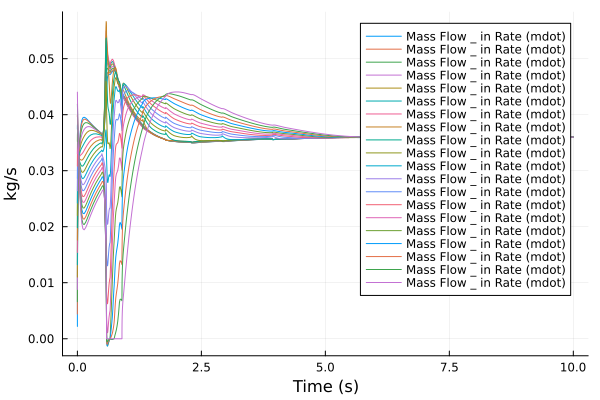

In [115]:
function plot_the_res(sol, N=N)
    # 1. Data extraction
    sol_t = sol[1]
    P_sol = sol[2]
    # h_sol : h1, h2, ... array
    h_sols = sol[3:(2+N)]
    mdot_sols = sol[(3+N):(2+2*N)]
    rho_sols = sol[(3+2*N):(2+3*N)]
    UA_elem_hat_sols = sol[(3+3*N):(2+4*N)]
    UA_elem_sols = sol[(3+4*N):(2+5*N)]

    x_sols = [(h_sol - R410a_h_L.(P_sol)) ./ (R410a_h_V.(P_sol) - R410a_h_L.(P_sol)) for h_sol in h_sols]

    # Restrict view to t >= 0.4
    i0 = findfirst(>=(0.01), sol_t)
    i0 === nothing && (i0 = 1)
    t_view = sol_t[i0:end]
    P_view = P_sol[i0:end]

    # 2. Plot
    p1 = Plots.plot(sol_t, P_sol ./ 1e3, label="Pressure (P)", xlabel="Time (s)", ylabel="kPa")
    p2 = Plots.plot(sol_t, h_sols./ 1e3, xlabel="Time (s)", ylabel="kJ/kg", legend=:best)
    p3 = Plots.plot(sol_t, mdot_sols[1:end], label="Mass Flow _ in Rate (mdot)", xlabel="Time (s)", ylabel="kg/s")
    p4 = Plots.plot(sol_t, mdot_sols[3], label="Mass Flow _ out Rate (mdot)", xlabel="Time (s)", ylabel="kg/s")
    p5 = Plots.plot(sol_t, rho_sols, label="Density (ρ)", xlabel="Time (s)", ylabel="kg/m³")
    # return Plots.plot(p1 ,p4, layout=(1, 2))
    p6 = Plots.plot(sol_t, x_sols[1:end], label="Quality (x)", xlabel="Time (s)", ylabel=" ")
    p7 = Plots.plot(sol_t, UA_elem_hat_sols[1:end], label="UA_elem_hat", xlabel="Time (s)", ylabel="W/K")
    p8 = Plots.plot(sol_t, UA_elem_sols[1:end], label="UA_elem", xlabel="Time (s)", ylabel="W/K")
    # return Plots.plot(p7, p8, layout=(1, 2), label=nothing)
    return p3
end

plot_the_res(sol_real)
